# Лабораторная работа №3 - Управление манипуляционным роботом
### Абрамов Максим Витальевич R4134с
### Цель:
> Решить задачу движения по траектории для
 многозвенного манипуляционного робота с помощью ПД-регулятора.
### Задачи:
 > 1. По выбранному варианту кинематики робота(см. таблицу 2.1)
 загрузить модель манипулятора из программного пакета.
 2. Заполнить все параметры модели робота согласно лабораторной работе №1.
 3. Задать желаемую траекторию движения манипулятора согласно лабораторной работе №2.
 4. Создать модель системы управления роботом, реализующую
 регулирование на основе обратной модели динамики. В работе рекомендуется синтезировать ПД-регулятор (допустимо использование других регуляторов).
 5. Настроить коэффициенты регулятора, минимизирующие
 ошибку обобщенных координат звеньев.
 6. Вывести графики изменения положения, скорости и момента
 для каждого из звеньев робота при движении вдоль траектории.
 7. Добавить полезную нагрузку и повторить пункты № 5-6.
 8. Составить отчёт в формате `.ipynb` (см. приложение В).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from roboticstoolbox import models
import roboticstoolbox as rtb



 ### 1. По выбранному варианту кинематики робота(см. таблицу 2.1) загрузить модель манипулятора из программного пакета.

In [2]:
robot = models.DH.UR5()

### 2. Заполнить все параметры модели робота согласно лабораторной работе №1.

In [3]:
# Массы звеньев (кг)
masses = [3.7, 6.8, 4.8, 0.8, 0.8, 0.8]

# Центр масс каждого звена (в локальной системе координат)
centers_of_mass = [
    [0, 0, -0.08],   # Звено 1
    [0, -0.12, 0],   # Звено 2
    [0, 0, -0.12],   # Звено 3
    [0, 0, 0],       # Звено 4
    [0, 0, 0],       # Звено 5
    [0, 0, 0]        # Звено 6
]

# Тензоры инерции (Lxx, Lyy, Lzz, Lxy, Lyz, Lxz)
inertias = [
    [0.0, 0.09, 0.09, 0, 0, 0],         # Звено 1
    [0.23, 0.2, 0.03, 0, 0, 0],         # Звено 2
    [0.02, 0.02, 0.03, 0, 0, 0],        # Звено 3
    [0.001, 0.001, 0.001, 0, 0, 0],     # Звено 4
    [0.001, 0.001, 0.001, 0, 0, 0],     # Звено 5
    [0.001, 0.001, 0.001, 0, 0, 0]      # Звено 6
]

# Момент инерции двигателей (примерно)
Jm = [0.0001, 0.0004, 0.0001, 0.00001, 0.00001, 0.00001]

# Коэффициенты вязкого трения
B = [0.1, 0.1, 0.05, 0.01, 0.01, 0.01]

# Коэффициенты кулоновского трения (±)
Tc = [0.3, 0.5, 0.3, 0.1, 0.1, 0.1]

# Передаточные числа редукторов
G = [100, 100, 100, 50, 50, 50]

# Ограничения по обобщенным координатам (радианы)
qlim = [
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi]
]

# Присвоение динамических параметров каждому звену
for i in range(6):
    robot.links[i].m = masses[i]
    robot.links[i].r = centers_of_mass[i]
    robot.links[i].I = inertias[i]
    robot.links[i].Jm = Jm[i]
    robot.links[i].B = B[i]
    robot.links[i].Tc = Tc[i]
    robot.links[i].G = G[i]
    robot.links[i].qlim = qlim[i]

### 3. Задать желаемую траекторию движения манипулятора согласно лабораторной работе №2.

In [4]:
# Произвольные начальная и конечная конфигурации
q_start = np.array([0, -np.pi/2, np.pi/2, 0, np.pi/2, 0])
q_end = np.array([np.pi/2, -np.pi/3, np.pi/3, 0, np.pi/2, 0])


In [5]:
# Задание временного массива
dt = 0.1
mT = 5
steps = int(mT / dt)
time_array = np.linspace(0, mT, steps)


In [6]:
tr_1 = rtb.mtraj(rtb.trapezoidal, q_start, q_end, time_array)

In [7]:
q_d_array = tr_1.q
qd_d_array = tr_1.qd
qdd_d_array = tr_1.qdd


### 4. Создать модель системы управления роботом, реализующую регулирование на основе обратной модели динамики. В работе рекомендуется синтезировать ПД-регулятор (допустимо использование других регуляторов).


In [9]:

def PD_regulator(robot, t, q_act, qd_act):

    mask = np.round(np.abs(time_array - t), 3) <= dt
    list_idx = np.array(range(len(mask)))
    idx_array = list_idx[mask]

    idx = idx_array[0] if idx_array.size > 0 else 0

    q_des = tr_1.q[idx]
    qd_des = tr_1.qd[idx]
    qdd_des = tr_1.qdd[idx]

    q_err = q_des - q_act
    qd_err = qd_des - qd_act
 
    M = robot.inertia(q_act)
    C = robot.coriolis(q_act, qd_act)
    G = robot.gravload(q_act)

    tau = Kp @ q_err + Kd @ qd_err + M @ qdd_des + C @ qd_des + G

    torques.append(tau)
    errors.append(q_err)

    return tau



 ### 5. Настроить коэффициенты регулятора, минимизирующие ошибку обобщенных координат звеньев.

In [ ]:
Kp = np.diag([470000, 497000, 19000, 37000, 39700, 19000])
Kd = np.diag([30000, 10000, 800, 800, 800, 800])

torques = []
errors = []

### 6. Вывести графики изменения положения, скорости и момента для каждого из звеньев робота при движении вдоль траектории.

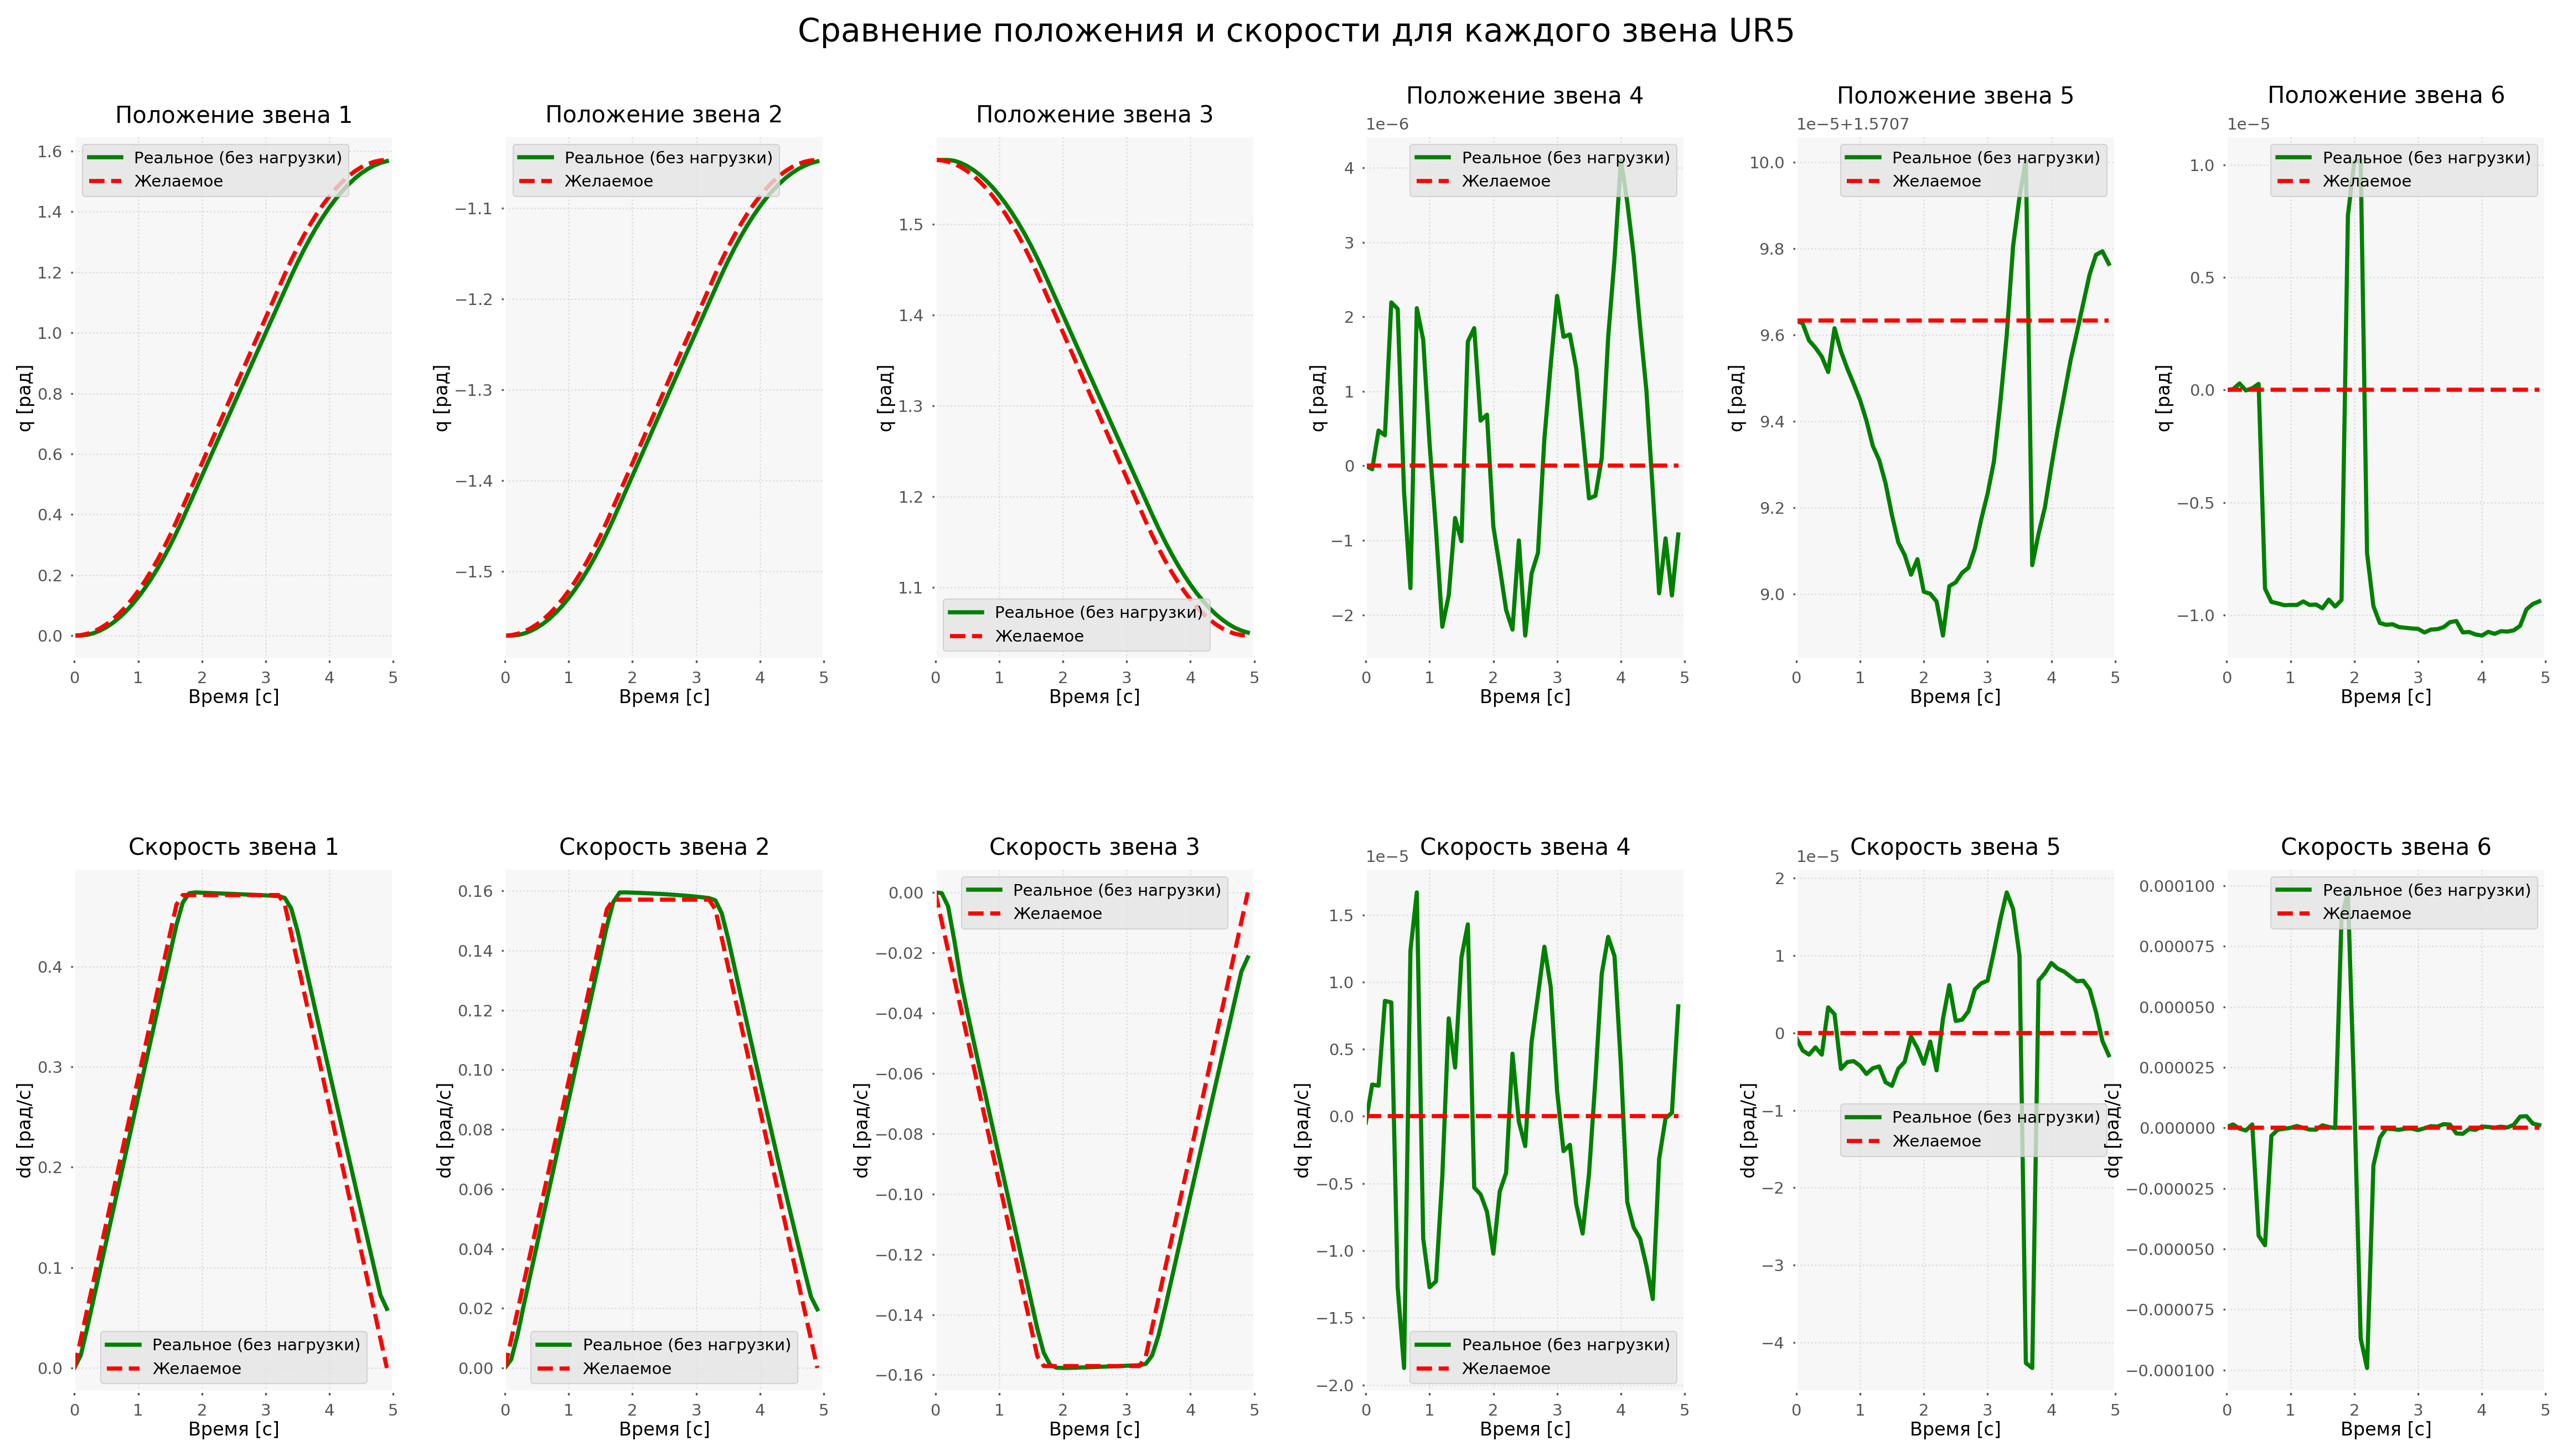

In [11]:
plt.figure(figsize=(16, 9), dpi=300)

colors = {
    'actual': 'green',     
    'desired': 'red',     
}

for i in range(6):
    # --- Положение звена ---
    plt.subplot(2, 6, i + 1)
    q_act = tg.q[:, i]
    q_des = tr_1.q[:, i]

    plt.plot(tg.t, q_act, linestyle='-', linewidth=1.8, color=colors['actual'], label="Реальное (без нагрузки)")
    plt.plot(tg.t, q_des, linestyle='--', linewidth=1.8, color=colors['desired'], label="Желаемое")
    plt.title(f"Положение звена {i+1}", fontsize=10)
    plt.xlabel("Время [с]", fontsize=8)
    plt.ylabel("q [рад]", fontsize=8)
    plt.grid(True, linestyle=':', linewidth=0.6)
    plt.legend(fontsize=7)
    plt.xlim(0, mT)
    plt.gca().set_facecolor("#f7f7f7")

    # --- Скорость звена ---
    plt.subplot(2, 6, i + 7)
    qd_act = np.gradient(q_act, dt)
    qd_des = tr_1.qd[:, i]

    plt.plot(tg.t, qd_act, linestyle='-', linewidth=1.8, color=colors['actual'], label="Реальное (без нагрузки)")
    plt.plot(tg.t, qd_des, linestyle='--', linewidth=1.8, color=colors['desired'], label="Желаемое")
    plt.title(f"Скорость звена {i+1}", fontsize=10)
    plt.xlabel("Время [с]", fontsize=8)
    plt.ylabel("dq [рад/с]", fontsize=8)
    plt.grid(True, linestyle=':', linewidth=0.6)
    plt.legend(fontsize=7)
    plt.xlim(0, mT)
    plt.gca().set_facecolor("#f7f7f7")

plt.suptitle("Сравнение положения и скорости для каждого звена UR5", fontsize=14)
plt.subplots_adjust(left=0.04, bottom=0.06, right=0.97, top=0.90, wspace=0.35, hspace=0.4)
plt.show()




### 7. Добавить полезную нагрузку и повторить пункты № 5-6.

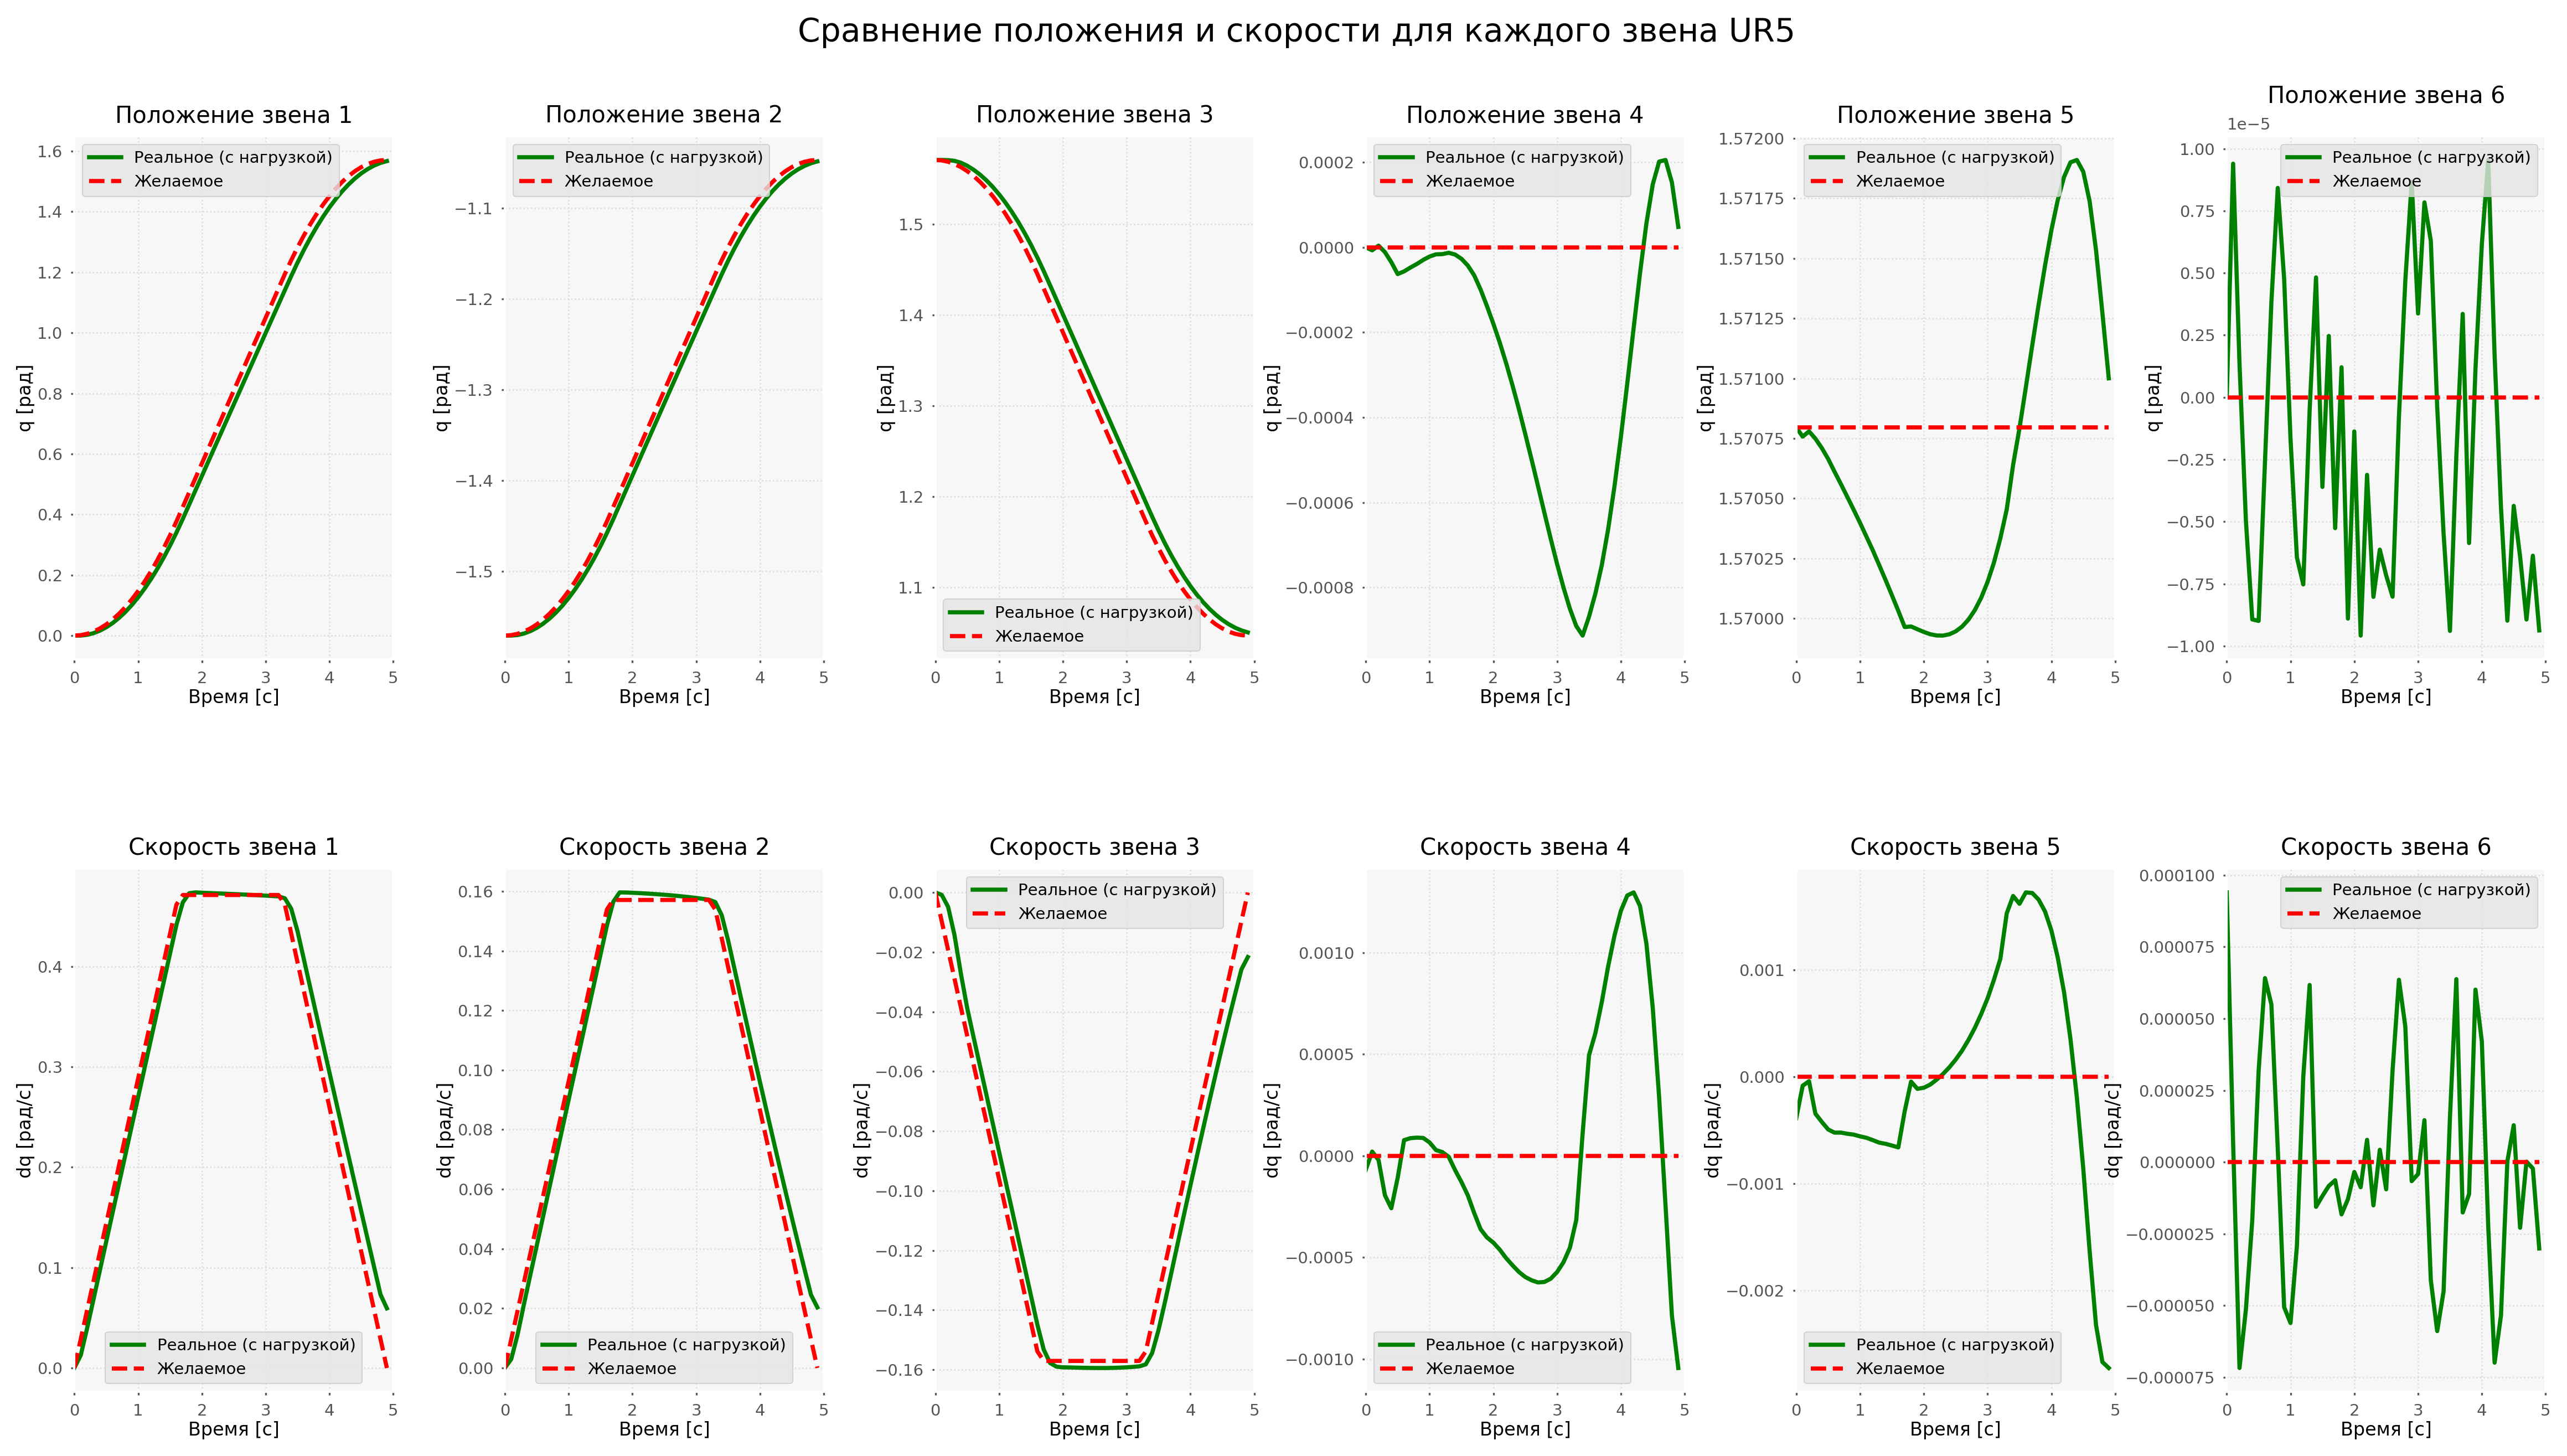

In [11]:
plt.figure(figsize=(16, 9), dpi=300)

colors = {
    'actual': 'green',     # фактическое положение — зелёный
    'desired': 'red',      # желаемое — красный
}

for i in range(6):
    # --- Положение звена ---
    plt.subplot(2, 6, i + 1)
    q_act = tg_we.q[:, i]
    q_des = tr_1.q[:, i]

    plt.plot(tg_we.t, q_act, linestyle='-', linewidth=1.8, color=colors['actual'], label="Реальное (с нагрузкой)")
    plt.plot(tg_we.t, q_des, linestyle='--', linewidth=1.8, color=colors['desired'], label="Желаемое")
    plt.title(f"Положение звена {i+1}", fontsize=10)
    plt.xlabel("Время [с]", fontsize=8)
    plt.ylabel("q [рад]", fontsize=8)
    plt.grid(True, linestyle=':', linewidth=0.6)
    plt.legend(fontsize=7)
    plt.xlim(0, mT)
    plt.gca().set_facecolor("#f7f7f7")

    # --- Скорость звена ---
    plt.subplot(2, 6, i + 7)
    qd_act = np.gradient(q_act, dt)
    qd_des = tr_1.qd[:, i]

    plt.plot(tg_we.t, qd_act, linestyle='-', linewidth=1.8, color=colors['actual'], label="Реальное (с нагрузкой)")
    plt.plot(tg_we.t, qd_des, linestyle='--', linewidth=1.8, color=colors['desired'], label="Желаемое")
    plt.title(f"Скорость звена {i+1}", fontsize=10)
    plt.xlabel("Время [с]", fontsize=8)
    plt.ylabel("dq [рад/с]", fontsize=8)
    plt.grid(True, linestyle=':', linewidth=0.6)
    plt.legend(fontsize=7)
    plt.xlim(0, mT)
    plt.gca().set_facecolor("#f7f7f7")

plt.suptitle("Сравнение положения и скорости для каждого звена UR5", fontsize=14)
plt.subplots_adjust(left=0.04, bottom=0.06, right=0.97, top=0.90, wspace=0.35, hspace=0.4)
plt.show()


 ## Выводы о проделанной работе:
 > В рамках лабораторной работы была решена задача управления многозвенным манипуляционным роботом с использованием ПД-регулятора. На основе выбранной кинематической структуры была загружена модель манипулятора `UR5`, все параметры которой были приведены в соответствие с результатами первой лабораторной работы. Заданная траектория движения, спланированная во второй лабораторной работе, использовалась как эталон для построения управляющих воздействий.
>
> Для управления движением манипулятора был синтезирован ПД-регулятор. Путем подбора коэффициентов пропорциональной и дифференциальной составляющих удалось достичь устойчивого движения по заданной траектории с минимальной ошибкой в обобщённых координатах.
> 
> Дополнительно была рассмотрена задача управления при наличии полезной нагрузки. Это позволило проанализировать влияние дополнительной массы на динамику системы и адаптивность регулятора. Результаты показали, что корректно настроенный ПД-регулятор способен обеспечить приемлемое качество управления даже при изменении динамических свойств робота.


